## Get Census data

Load tract geometry and kek demogrpahic measures from NYC and Census APIs

You will need this for [`Compare demographics`](Compare%20demographics.ipynb)

Or use this standalone for loading Census geometry and data for New York City.

In [1]:
import pandas as pd
import geopandas as gpd
import requests

#### get geometries

In [2]:
# from https://www.nyc.gov/site/planning/data-maps/open-data/census-download-metadata.page

# tracts = gpd.read_file('https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Census_Tracts_for_2020_US_Census/FeatureServer/0/query?where=1=1&outFields=GEOID&outSR=2263&f=pgeojson')

In [3]:
# if there are problems reading from above, try this to request and load data

tracts_url = 'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Census_Tracts_for_2020_US_Census/FeatureServer/0/query?where=1=1&outFields=GEOID&outSR=2263&f=pgeojson'

tracts_r = requests.get(tracts_url)

tracts = gpd.GeoDataFrame.from_features(
    tracts_r.json(),
    crs=tracts_r.json()['crs']['properties']['name']
)

In [4]:
# ntas_crosswalk = gpd.read_file(
#     'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Census_Tracts_for_2020_US_Census/FeatureServer/0//query?where=1%3D1&outFields=GEOID%2CNTA2020%2CCDTA2020&returnGeometry=false&f=pjson'
# )

In [5]:
# tracts = (
#     tracts
#     .merge(
#         ntas_crosswalk[['GEOID','NTA2020','CDTA2020']],
#         on='GEOID',
#         how='left',
#         validate='m:1'
#     )
# )

In [6]:
def compute_rates(in_df, total_col, subtotal_cols):

    out_df = in_df.copy()

    out_df = (
        out_df
        .join(
            in_df[subtotal_cols]
            .div(
                in_df[total_col],
                axis=0
            )
            .add_suffix('__pct')
        )
    )

    return out_df

### get ACS data

In [7]:
ACS_VARS = {
    'B03002_001E': 'Total population',
    'B03002_003E': 'White',
    'B03002_004E': 'Black',
    'B03002_006E': 'Asian',
    'B03002_012E': 'Hispanic',
    'B06011_001E':'median_income',
    'B06012_002E':'below_poverty_level',
    'B06012_003E':'100_to_150_pct_poverty_level'
}

In [8]:
acs_url = 'https://api.census.gov/data/2021/acs/acs5/variables?get=' + ','.join(ACS_VARS) + '&for=tract:*&in=state:36&in=county:005,047,061,081,085'

acs_r = requests.get(acs_url)

assert acs_r.status_code == 200, f'error in response: {acs_r.text}'

acs_data = acs_r.json()

In [9]:
census_acs_data = (
    pd.DataFrame(
        acs_data[1:], 
        columns=acs_data[0],
        dtype=str)
    .assign(
        GEOID = lambda row: row['state'] + row['county'] + row['tract']
    )
    .drop(columns=['state','county','tract'])
    .rename(columns=ACS_VARS)
    .set_index('GEOID')
    .apply(pd.to_numeric)
    .where(lambda a: a > 0) # replace negative number indicator values with NaNs 
    .assign(
        below_150_pct_poverty_level = lambda row: row['below_poverty_level'] + row['100_to_150_pct_poverty_level']
    )
    .add_suffix('__ACS_2021')
)

In [10]:
census_acs_data.isna().mean()

Total population__ACS_2021                0.037817
White__ACS_2021                           0.055436
Black__ACS_2021                           0.108294
Asian__ACS_2021                           0.117318
Hispanic__ACS_2021                        0.044263
median_income__ACS_2021                   0.042544
below_poverty_level__ACS_2021             0.045552
100_to_150_pct_poverty_level__ACS_2021    0.058015
below_150_pct_poverty_level__ACS_2021     0.060163
dtype: float64

In [11]:
tracts = (
    tracts
    .set_index('GEOID')
    .join(census_acs_data)
)

In [12]:
acs_total_col = 'Total population__ACS_2021'

acs_subtotal_cols = [
    'White__ACS_2021', 
    'Black__ACS_2021',
    'Asian__ACS_2021',
    'Hispanic__ACS_2021', 
    'below_poverty_level__ACS_2021',
    '100_to_150_pct_poverty_level__ACS_2021', 
    'below_150_pct_poverty_level__ACS_2021'
]

In [13]:
tracts = compute_rates(tracts, acs_total_col, acs_subtotal_cols)

### get Decennial

In [14]:
DEC_VARS = {
    'DP1_0092C': 'Total population',
    'DP1_0105C': 'White',
    'DP1_0106C': 'Black',
    'DP1_0108C': 'Asian',
    'DP1_0096C': 'Hispanic',
}

In [15]:
dec_url = 'https://api.census.gov/data/2020/dec/dp?get=' + ','.join(DEC_VARS) + '&for=tract:*&in=state:36&in=county:005,047,061,081,085'

dec_r = requests.get(dec_url)

assert dec_r.status_code == 200, f'error in response: {dec_r.text}'

dec_data = dec_r.json()

In [16]:
census_dec_data = (
    pd.DataFrame(
        dec_data[1:], 
        columns=dec_data[0],
        dtype=str)
    .assign(
        GEOID = lambda row: row['state'] + row['county'] + row['tract']
    )
    .drop(columns=['state','county','tract'])
    .rename(columns=DEC_VARS)
    .set_index('GEOID')
    .apply(pd.to_numeric)
    .where(lambda a: a > 0) # replace negative number indicator values with NaNs 
    .add_suffix('__2020')
)

In [17]:
census_dec_data

,Total population__2020,White__2020,Black__2020,Asian__2020,Hispanic__2020
GEOID,,,,,
36005000100,3772.0,260.0,2172.0,59.0,1259.0
36005000200,4779.0,152.0,1011.0,202.0,3173.0
36005000400,6272.0,238.0,1592.0,230.0,3972.0
36005001600,5795.0,121.0,1884.0,122.0,3479.0
36005001901,2292.0,250.0,803.0,39.0,1089.0
...,...,...,...,...,...
36085030302,6669.0,1622.0,1284.0,1219.0,2306.0
36085031901,3262.0,179.0,1526.0,181.0,1218.0
36085031902,5500.0,472.0,2904.0,111.0,1722.0


In [18]:
census_dec_data.isna().mean()

Total population__2020    0.015041
White__2020               0.028363
Black__2020               0.030082
Asian__2020               0.035668
Hispanic__2020            0.020627
dtype: float64

In [19]:
tracts = (
    tracts
    .join(census_dec_data)
)

In [20]:
dec_total_col = 'Total population__2020'

dec_subtotal_cols = [
    'White__2020', 
    'Black__2020',
    'Asian__2020',
    'Hispanic__2020', 
]


In [21]:
tracts = compute_rates(tracts, dec_total_col, dec_subtotal_cols)

In [22]:
tracts

,geometry,Total population__ACS_2021,White__ACS_2021,Black__ACS_2021,Asian__ACS_2021,Hispanic__ACS_2021,median_income__ACS_2021,below_poverty_level__ACS_2021,100_to_150_pct_poverty_level__ACS_2021,below_150_pct_poverty_level__ACS_2021,...,below_150_pct_poverty_level__ACS_2021__pct,Total population__2020,White__2020,Black__2020,Asian__2020,Hispanic__2020,White__2020__pct,Black__2020__pct,Asian__2020__pct,Hispanic__2020__pct
GEOID,,,,,,,,,,,,,,,,,,,,,
36061000100,"MULTIPOLYGON (((972081.788 190733.467, 972184....",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36061000201,"POLYGON ((988548.218 197770.375, 987978.808 19...",2740.0,185.0,91.0,614.0,1787.0,18100.0,1474.0,231.0,1705.0,...,0.622263,2012.0,221.0,244.0,702.0,784.0,0.109841,0.121272,0.348907,0.389662
36061000600,"POLYGON ((986961.185 199553.643, 987206.139 19...",10732.0,664.0,707.0,5425.0,3556.0,14493.0,4075.0,2015.0,6090.0,...,0.567462,11616.0,1145.0,1227.0,6027.0,2946.0,0.098571,0.105630,0.518853,0.253616
36061001401,"POLYGON ((987475.016 200297.218, 987705.443 20...",3071.0,2217.0,169.0,318.0,233.0,55438.0,247.0,52.0,299.0,...,0.097362,3543.0,2080.0,88.0,718.0,416.0,0.587073,0.024838,0.202653,0.117415
36061001402,"POLYGON ((988387.669 201258.312, 988621.002 20...",3133.0,801.0,254.0,1045.0,875.0,37880.0,906.0,274.0,1180.0,...,0.376636,3418.0,957.0,287.0,1023.0,996.0,0.279988,0.083967,0.299298,0.291398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36047114600,"POLYGON ((1015036.483 186512.548, 1014795.650 ...",3119.0,49.0,605.0,214.0,2140.0,27635.0,755.0,162.0,917.0,...,0.294004,3134.0,74.0,697.0,157.0,2012.0,0.023612,0.222399,0.050096,0.641991
36081037300,"POLYGON ((1023100.807 216865.154, 1023276.361 ...",2293.0,91.0,162.0,349.0,1604.0,33924.0,305.0,286.0,591.0,...,0.257741,2887.0,50.0,354.0,229.0,2179.0,0.017319,0.122619,0.079321,0.754763
36081038100,"POLYGON ((1024941.562 214417.499, 1024910.764 ...",7058.0,343.0,673.0,320.0,5582.0,28663.0,931.0,379.0,1310.0,...,0.185605,6966.0,90.0,771.0,416.0,5540.0,0.012920,0.110680,0.059719,0.795291


### save out

In [23]:
tracts.to_file('../tract_data.geojson')

### check it. 

In [24]:
tracts

,geometry,Total population__ACS_2021,White__ACS_2021,Black__ACS_2021,Asian__ACS_2021,Hispanic__ACS_2021,median_income__ACS_2021,below_poverty_level__ACS_2021,100_to_150_pct_poverty_level__ACS_2021,below_150_pct_poverty_level__ACS_2021,...,below_150_pct_poverty_level__ACS_2021__pct,Total population__2020,White__2020,Black__2020,Asian__2020,Hispanic__2020,White__2020__pct,Black__2020__pct,Asian__2020__pct,Hispanic__2020__pct
GEOID,,,,,,,,,,,,,,,,,,,,,
36061000100,"MULTIPOLYGON (((972081.788 190733.467, 972184....",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36061000201,"POLYGON ((988548.218 197770.375, 987978.808 19...",2740.0,185.0,91.0,614.0,1787.0,18100.0,1474.0,231.0,1705.0,...,0.622263,2012.0,221.0,244.0,702.0,784.0,0.109841,0.121272,0.348907,0.389662
36061000600,"POLYGON ((986961.185 199553.643, 987206.139 19...",10732.0,664.0,707.0,5425.0,3556.0,14493.0,4075.0,2015.0,6090.0,...,0.567462,11616.0,1145.0,1227.0,6027.0,2946.0,0.098571,0.105630,0.518853,0.253616
36061001401,"POLYGON ((987475.016 200297.218, 987705.443 20...",3071.0,2217.0,169.0,318.0,233.0,55438.0,247.0,52.0,299.0,...,0.097362,3543.0,2080.0,88.0,718.0,416.0,0.587073,0.024838,0.202653,0.117415
36061001402,"POLYGON ((988387.669 201258.312, 988621.002 20...",3133.0,801.0,254.0,1045.0,875.0,37880.0,906.0,274.0,1180.0,...,0.376636,3418.0,957.0,287.0,1023.0,996.0,0.279988,0.083967,0.299298,0.291398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36047114600,"POLYGON ((1015036.483 186512.548, 1014795.650 ...",3119.0,49.0,605.0,214.0,2140.0,27635.0,755.0,162.0,917.0,...,0.294004,3134.0,74.0,697.0,157.0,2012.0,0.023612,0.222399,0.050096,0.641991
36081037300,"POLYGON ((1023100.807 216865.154, 1023276.361 ...",2293.0,91.0,162.0,349.0,1604.0,33924.0,305.0,286.0,591.0,...,0.257741,2887.0,50.0,354.0,229.0,2179.0,0.017319,0.122619,0.079321,0.754763
36081038100,"POLYGON ((1024941.562 214417.499, 1024910.764 ...",7058.0,343.0,673.0,320.0,5582.0,28663.0,931.0,379.0,1310.0,...,0.185605,6966.0,90.0,771.0,416.0,5540.0,0.012920,0.110680,0.059719,0.795291


<Axes: >

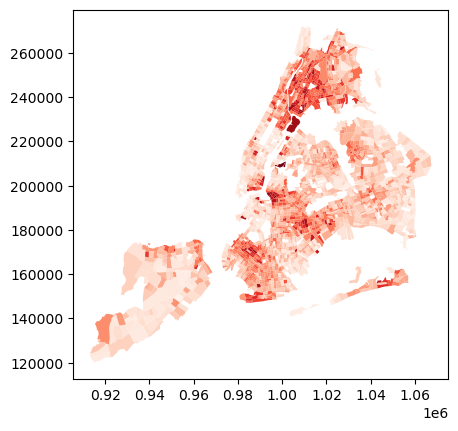

In [25]:
tracts.plot(
    column='below_150_pct_poverty_level__ACS_2021__pct',
    cmap='Reds'
)

<Axes: >

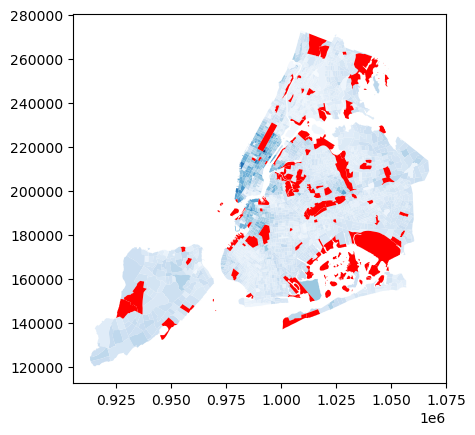

In [26]:
(
    tracts
    .plot(
        column='median_income__ACS_2021',
        cmap='Blues',
        missing_kwds={
            'color':'red'
        }
    )
)